### Midterm Project - Ruggiero Julian
## Analysis of COVID-19 on NYC Boroughs and Zip Codes

In [1]:
# importing libraries needed
import scipy.stats as stats
import math
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,4)

### First Data Source
https://github.com/nychealth/coronavirus-data/blob/master/tests-by-zcta.csv
<br><br> Comes daily from the NYC Department of Health and Mental Hygiene (DOHMH) Incident Command System for COVID-19 Response.
- MODZCTA: NYC zipcode
- Positive: Cumulative tested positive counts in the zip code.
- Total: Were ever tested for COVID-19 (SARS-CoV-2)
- zcta_cum.perc_pos: ratio Positive/Total

In [2]:
#data as of 05-22-2020
covid_data=pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/3cbb3b744ed90befb37ea7680fac3aa7f782bb30/tests-by-zcta.csv')

#renaming column
covid_data.rename(columns = {'MODZCTA':'zip_code', 'zcta_cum.perc_pos':'ratio', 'Positive':'covid_positive', 'Total':'covid_tested'}, inplace=True)
covid_data.head()

,zip_code,covid_positive,covid_tested,ratio
0,NaN,5795,6343,91.36
1,10001.0,341,1552,21.97
2,10002.0,989,3164,31.26
3,10003.0,434,2220,19.55
4,10004.0,30,153,19.61


In [3]:
print('Citywide', covid_data['covid_positive'][0], 'people who have tested positive are not listed as a resident of any ZIP code.')

Citywide 5795 people who have tested positive are not listed as a resident of any ZIP code.


### Second Data Source
https://github.com/gitjuli/covid-19/blob/master/uszips.csv
<br><br> Comes from https://simplemaps.com/data/us-zips have population data in the us for each zip code. Data from 2016.
- zip: US zip-code
- Population: zip-code population in 2016
- Density: people per sq km

In [4]:
population=pd.read_csv('https://raw.githubusercontent.com/gitjuli/covid-19/master/uszips.csv')
population.rename(columns = {'zip':'zip_code'}, inplace=True)

# merge
covid_data = pd.merge(covid_data[covid_data['zip_code'].notna()], population, how='inner', on=['zip_code'])
covid_data.head()

,zip_code,covid_positive,covid_tested,ratio,population,density
0,10001.0,341,1552,21.97,22924,13259.3
1,10002.0,989,3164,31.26,74993,35781.9
2,10003.0,434,2220,19.55,54682,37524.3
3,10004.0,30,153,19.61,3028,2214.8
4,10005.0,59,372,15.86,8831,37900.9


### Third Data Source
https://github.com/gitjuli/covid-19/blob/master/usincome.csv
<br><br> Data extracted from US Census and Bureau reports.
- zip: US zip-code
- Median: Median population income
- Mean: Mean population income

In [5]:
#get income data
income=pd.read_csv('https://raw.githubusercontent.com/gitjuli/covid-19/master/usincome.csv')
income.rename(columns = {'Zip':'zip_code', 'Median':'median_income', 'Mean':'mean_income'}, inplace=True)

# merge
covid_data = pd.merge(covid_data[covid_data['zip_code'].notna()], income, how='inner', on=['zip_code'])
covid_data.head()

,zip_code,covid_positive,covid_tested,ratio,population,density,median_income,mean_income
0,10001.0,341,1552,21.97,22924,13259.3,71245,123113
1,10002.0,989,3164,31.26,74993,35781.9,30844,46259
2,10003.0,434,2220,19.55,54682,37524.3,89999,139331
3,10004.0,30,153,19.61,3028,2214.8,110184,156683
4,10005.0,59,372,15.86,8831,37900.9,115133,163763


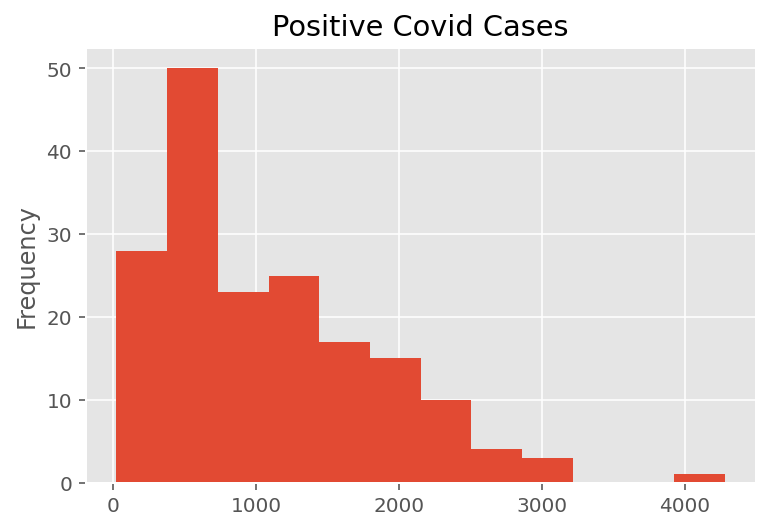

In [6]:
#histogram of covid positive(+) cases
covid_data[covid_data['zip_code'].notna()].covid_positive.plot.hist(bins=12)
plt.title('Positive Covid Cases');

In [7]:
#get positive stats
positive_stats=covid_data[covid_data['zip_code'].notna()].covid_positive.describe()
positive_stats

count     176.00000
mean     1065.43750
std       752.66197
min        23.00000
25%       498.50000
50%       876.50000
75%      1507.50000
max      4283.00000
Name: covid_positive, dtype: float64

In [8]:
print('The histogram data shows a right skewed distribution for the positive cases, with a mean of {} per zip code and a std of {}'.format(
positive_stats[1],positive_stats[2]))

The histogram data shows a right skewed distribution for the positive cases, with a mean of 1065.4375 per zip code and a std of 752.6619704659685


### Fourth Data Source
https://github.com/gitjuli/covid-19/blob/master/zip_borough.csv
<br><br> Contains a list of zip code with the corresponding borough name.
- Zip: NYC zipcode.
- Borough: NYC borough name.

In [9]:
#data source 2 (zip code by borough)
borough=pd.read_csv('https://raw.githubusercontent.com/gitjuli/covid-19/master/zip_borough.csv')
borough.rename(columns = {'zip':'zip_code'}, inplace=True)

#merge
covid_data = pd.merge(covid_data[covid_data['zip_code'].notna()], borough, how='inner', on=['zip_code'])
covid_data["zip_code"]=covid_data["zip_code"].astype(int).astype(str) 
covid_data["mean_income"]=covid_data["mean_income"].astype(int)
covid_data.head()

,zip_code,covid_positive,covid_tested,ratio,population,density,median_income,mean_income,borough
0,10001,341,1552,21.97,22924,13259.3,71245,123113,Manhattan
1,10002,989,3164,31.26,74993,35781.9,30844,46259,Manhattan
2,10003,434,2220,19.55,54682,37524.3,89999,139331,Manhattan
3,10004,30,153,19.61,3028,2214.8,110184,156683,Manhattan
4,10005,59,372,15.86,8831,37900.9,115133,163763,Manhattan


### Normalization on zip code density
<br>
Creating new field 'positive_per_thousand' which will have number of positive cases per thousand people living in that zip code.

In [10]:
covid_data["positive_per_thousand"]=(1000 * covid_data["covid_positive"])/covid_data["population"]
covid_data.head()

,zip_code,covid_positive,covid_tested,ratio,population,density,median_income,mean_income,borough,positive_per_thousand
0,10001,341,1552,21.97,22924,13259.3,71245,123113,Manhattan,14.875240
1,10002,989,3164,31.26,74993,35781.9,30844,46259,Manhattan,13.187898
2,10003,434,2220,19.55,54682,37524.3,89999,139331,Manhattan,7.936798
3,10004,30,153,19.61,3028,2214.8,110184,156683,Manhattan,9.907530
4,10005,59,372,15.86,8831,37900.9,115133,163763,Manhattan,6.681010


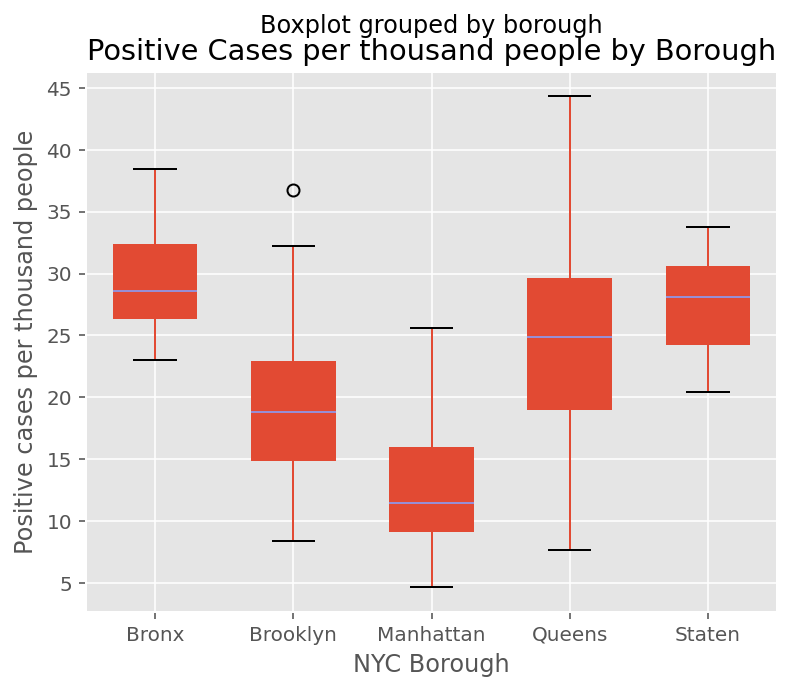

In [57]:
# boxplot NYC borough by number of positive per thousand cases
covid_data.boxplot(column='positive_per_thousand', by='borough', widths = 0.6,patch_artist = True,figsize=(6,5));
plt.xlabel("NYC Borough")
plt.ylabel("Positive cases per thousand people")
plt.title('Positive Cases per thousand people by Borough');

The box plot shows that Queens has the highest percentage of positive cases per thousand people living in their zip codes. The lenght of the distribution shows it has the largest number of zip-codes affected.

__Sergey Comment__ 1. For your analysis where you claim that queens has the highest percentage of positive cases per thousand people living in their zip codes is not confirmed using any kind of statistical test, so we have to take your result at face value. Something like an ANOVA would have worked well here, where if you could show that there was a significant F-score across boroughs (showing that there was a difference in means between them) and then a direct t-test between queens and either all of the other boroughs combined or each borough individually (if the t-test is significant on the all other boroughs vs queens test, then this would be sufficient).

__Comment 1 approach__ <br>
To check wether there is any difference in positive per thousand means among boroughs an ANOVA test is implemented, which uses a single hypothesis test to check whether the means across many groups are equal:
 - H0: The mean outcome is the same across all groups. In statistical notation, u1 = u2 = ..... = uk.
 - HA: At least one mean is different.
 
Chequing ANOVA conditions: <br>
__1) Independence:__ the data is a simple random sample from less than 10% of the population, this condition is satisfed. <br>
__2) Approximately normal:__ checking with probability plots.

In [12]:
#getting separate df for each borough
df_queens=covid_data[covid_data['borough'] == 'Queens']
df_brooklyn=covid_data[covid_data['borough'] == 'Brooklyn']
df_manhattan=covid_data[covid_data['borough'] == 'Manhattan']
df_bronx=covid_data[covid_data['borough'] == 'Bronx']
df_staten=covid_data[covid_data['borough'] == 'Staten']

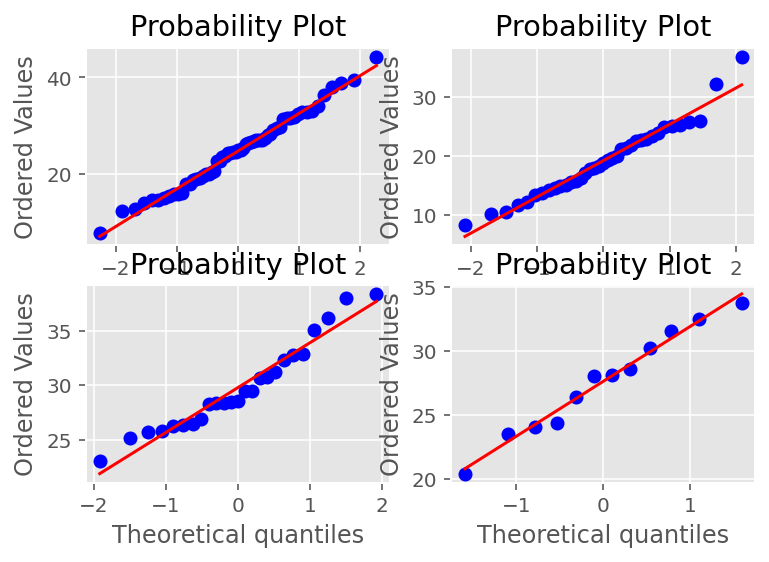

In [13]:
#checking condition with probability plots on each borough
from scipy.stats import probplot
plt.subplot(2, 2, 1)
probplot(df_queens.positive_per_thousand, plot = plt)
plt.subplot(2, 2, 2)
probplot(df_brooklyn.positive_per_thousand, plot = plt)
plt.subplot(2, 2, 3)
probplot(df_bronx.positive_per_thousand, plot = plt)
plt.subplot(2, 2, 4)
probplot(df_staten.positive_per_thousand, plot = plt)
plt.show(); 

Despite there is some deviation from normality, it isn't a substantial concern and the outliers are not extreme. <br>
__3) Constant Variance:__ check with side by side box-plot and with summary statistic table looking at the std between groups.

In [14]:
#summary stats about 'positive_per_thousand' per borough 
summary=covid_data.groupby(['borough']).positive_per_thousand.describe()
summary

,count,mean,std,min,25%,50%,75%,max
borough,,,,,,,,
Bronx,25.0,29.791662,4.051250,23.046689,26.387009,28.593052,32.281685,38.405307
Brooklyn,37.0,19.216894,6.055419,8.367068,14.914033,18.817296,22.886682,36.771368
Manhattan,41.0,13.314899,5.588642,4.688832,9.206845,11.489776,15.929322,25.571441
Queens,59.0,24.735082,7.683736,7.691022,19.051841,24.854311,29.549469,44.316783
Staten,12.0,27.640341,4.017911,20.439939,24.297638,28.079280,30.556807,33.728851


Whether these diferences are from natural variation is unclear, so we should report this uncertainty with the final results.

Using statsmodels to perform ANOVA.

In [15]:
# load packages
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Least Squares (OLS) model
model = ols('positive_per_thousand ~ C(borough)', data=covid_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(borough),5713.003106,4.0,36.765961,4.275134e-22
Residual,6565.158975,169.0,NaN,NaN


The P-value obtained from ANOVA analysis is <0.05, meaning that there are significant differences among boroughs positive per thousand means. To check which one is different from each other we will perform multiple pairwise comparison analysis using Tukey HSD test.

In [16]:
# load packages
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=covid_data['positive_per_thousand'], groups=covid_data['borough'], alpha=0.05)

print(m_comp)

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff  lower    upper   reject
-----------------------------------------------------
  Bronx    Brooklyn -10.5748 -15.0244 -6.1251   True 
  Bronx   Manhattan -16.4768 -20.838  -12.1155  True 
  Bronx     Queens  -5.0566  -9.1581  -0.9551   True 
  Bronx     Staten  -2.1513  -8.1872   3.8845  False 
 Brooklyn Manhattan  -5.902  -9.7992  -2.0048   True 
 Brooklyn   Queens   5.5182   1.914    9.1224   True 
 Brooklyn   Staten   8.4234   2.7139   14.133   True 
Manhattan   Queens  11.4202   7.9257  14.9146   True 
Manhattan   Staten  14.3254   8.6845  19.9664   True 
  Queens    Staten   2.9053  -2.5374   8.3479  False 
-----------------------------------------------------


Above results from Tukey HSD suggests that __except Bronx-Staten and Queens-Staten, all other pairwise comparisons for positive per thousand rejects null hypothesis and indicates statistical significant differences.__ <br>
This result is consistent with the side by side boxplot.

Manual method (without Turkey HSD test)

__1. Queens vs Brooklyn__

__H0:__ There is no difference in average positive cases per thousand people for zip codes from Queens and Brooklyn. In statistical notation: Uq - Ub = 0, where Uq represents Queens zip codes and Ub represents Brooklyn zip codes.

__HA:__ There is a difference in average positive cases per thousand people for zip codes from Queens and Brooklyn (Uq - Ub != 0).

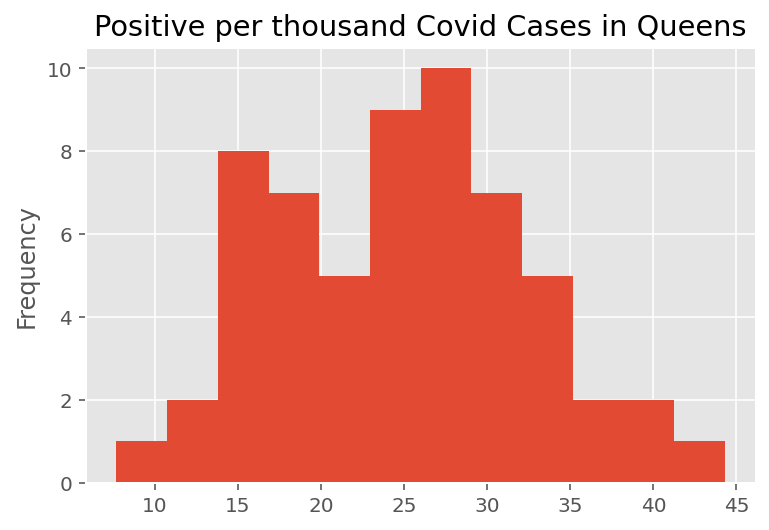

In [17]:
#Histogram of Positive per thousand cases in Queens
df_queens.positive_per_thousand.plot.hist(bins=12)
plt.title('Positive per thousand Covid Cases in Queens');

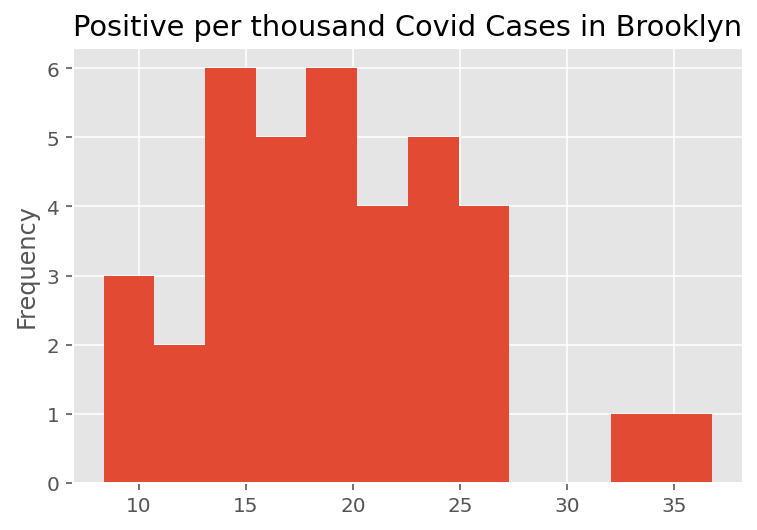

In [18]:
#Histogram of Positive per thousand cases in Brooklyn
df_brooklyn.positive_per_thousand.plot.hist(bins=12)
plt.title('Positive per thousand Covid Cases in Brooklyn');

We check the two conditions necessary to apply the t-distribution to the difference in sample means. (1) We assume the data come from a simple random sample and consist of less than 10% of all cases, the observations are independent. (2) Additionally, while each distribution is skewed, the sample sizes would make it reasonable to model each mean separately using a t-distribution. Since both conditions are satisfied, the difference in sample means may be modeled using a t-distribution.

In [19]:
#get queens stats
mean_queens=df_queens.positive_per_thousand.mean()
std_queens=df_queens.positive_per_thousand.std()
count_queens=df_queens.positive_per_thousand.count()

#get brooklyn stats
mean_brooklyn=df_brooklyn.positive_per_thousand.mean()
std_brooklyn=df_brooklyn.positive_per_thousand.std()
count_brooklyn=df_brooklyn.positive_per_thousand.count()

In [20]:
#get means difference
difference_sample_means=mean_queens - mean_brooklyn

#The standard error of the estimate
standard_error=math.sqrt((std_queens**2/count_queens) + (std_brooklyn**2/count_brooklyn))

#Compute the p-value of the hypothesis test
t_score=difference_sample_means/standard_error

In [21]:
#getting the p-value for a 2 side test
def check_hyphotesis(t_score, count1, count2):
    degress_fredom=0
    
    if count1>count2:
        degress_fredom=count2-1
    else:
        degress_fredom=count1-1
            
    p_value=(stats.t.sf(np.abs(t_score), degress_fredom)*2)
    
    #check if p-value is lower or larger than the signifficance level 0.05
    if (p_value>0.05):
        return 'Fail to reject null hypothesis, p-value = ' + str(p_value)
    else:
        return 'Reject null hypothesis, p-value = ' + str(p_value)

In [22]:
check_hyphotesis(t_score,count_queens,count_brooklyn)

'Reject null hypothesis, p-value = 0.00039163700053726974'

There is enough evidence to say that there is a difference in average positive cases per thousand people for zip codes __between Queens and Brooklyn.__

__2. Queens vs Manhattan__

In [23]:
#get manhattan stats
mean_manhattan=df_manhattan.positive_per_thousand.mean()
std_manhattan=df_manhattan.positive_per_thousand.std()
count_manhattan=df_manhattan.positive_per_thousand.count()

#get means difference
difference_sample_means=mean_queens - mean_manhattan

#The standard error of the estimate
standard_error=math.sqrt((std_queens**2/count_queens) + (std_manhattan**2/count_manhattan))

#Compute the p-value of the hypothesis test
t_score=difference_sample_means/standard_error

check_hyphotesis(t_score, count_queens, count_manhattan)

'Reject null hypothesis, p-value = 1.2295525625769433e-10'

__3. Queens vs Bronx__

In [24]:
#get Bronx stats
mean_bronx=df_bronx.positive_per_thousand.mean()
std_bronx=df_bronx.positive_per_thousand.std()
count_bronx=df_bronx.positive_per_thousand.count()

#get means difference
difference_sample_means=mean_queens - mean_bronx

#The standard error of the estimate
standard_error=math.sqrt((std_queens**2/count_queens) + (std_bronx**2/count_bronx))

#Compute the p-value of the hypothesis test
t_score=difference_sample_means/standard_error

check_hyphotesis(t_score, count_queens, count_bronx)

'Reject null hypothesis, p-value = 0.0006319179759812832'

__3. Queens vs Staten Island__

In [25]:
#get staten stats
mean_staten=df_staten.positive_per_thousand.mean()
std_staten=df_staten.positive_per_thousand.std()
count_staten=df_staten.positive_per_thousand.count()

#get means difference
difference_sample_means=mean_queens - mean_staten

#The standard error of the estimate
standard_error=math.sqrt((std_queens**2/count_queens) + (std_staten**2/count_staten))

#Compute the p-value of the hypothesis test
t_score=difference_sample_means/standard_error

check_hyphotesis(t_score, count_queens, count_staten)

'Fail to reject null hypothesis, p-value = 0.08440523402857764'

This matches results from the Turkey test.

### Linear model to predict positive based on median_income

__Sergey Comment__ 2. For your simple linear model attempting to predict positive cases using median income, you should have used cases per thousand for your outcome variable, not positive cases, because in general, zip codes with more people are more likely to have more positive cases, and there may also be a lurking variable where zipcodes with more people are correlated with income. The normalized positive case variable you created would have mitigated that issue.

__Comment 1 approach__ <br>
Using positive_per_thousand as the outcome variable.

In [26]:
# linear model to predict positive based on median_income

formula_string = "positive_per_thousand ~ mean_income"

model = sm.formula.ols(formula = formula_string, data = covid_data)
model_fitted = model.fit()
print(model_fitted.summary())

                              OLS Regression Results                             
Dep. Variable:     positive_per_thousand   R-squared:                       0.318
Model:                               OLS   Adj. R-squared:                  0.314
Method:                    Least Squares   F-statistic:                     80.12
Date:                   Thu, 28 May 2020   Prob (F-statistic):           5.55e-16
Time:                           13:00:13   Log-Likelihood:                -583.94
No. Observations:                    174   AIC:                             1172.
Df Residuals:                        172   BIC:                             1178.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      31.05

Intercept = 31.052450281842813
Slope = -0.00011987057813113796
Correlation between mean_income and Positive cases per thousand:  -0.564
R^2 of mean_income in predicting Positive cases per thousand:  0.318


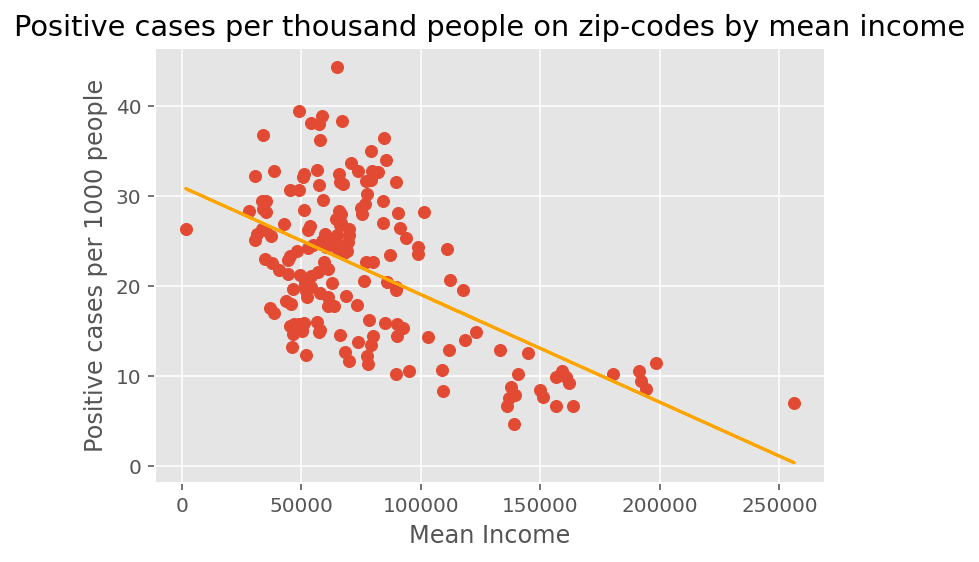

In [60]:
print('Intercept =', model_fitted.params[0])
print('Slope =', model_fitted.params[1])
print("Correlation between mean_income and Positive cases per thousand: ",np.round(covid_data.mean_income.corr(covid_data.positive_per_thousand),3))
print("R^2 of mean_income in predicting Positive cases per thousand: ",np.round(covid_data.mean_income.corr(covid_data.positive_per_thousand)**2,3))

x = covid_data['mean_income']
y = covid_data['positive_per_thousand']

y_pred = model_fitted.predict(x)

plt.scatter(covid_data['mean_income'], covid_data['positive_per_thousand'])
plt.plot(x, y_pred, color = 'orange')
plt.title('Positive cases per thousand people on zip-codes by mean income');
plt.xlabel('Mean Income')
plt.ylabel('Positive cases per 1000 people')
plt.show();

There is a negative association between mean_income and positive cases per thousand people, and mean income can explain around 32% of the variability found in number of Positive cases per thousand people.

Knowing the intercept and slope, we can write down the least squares regression line for the linear model:

#### ${y}$ = 31.05 - 0.00012 x (mean_income)

The slope is -0.00012, meaning that for every unit increase in mean_income, the positive cases per thousand decreases by 0.00013. Based on the low p value the mean_income is a statistically significant predictor, but the R-squared value is still low to say that is a significant predictor.

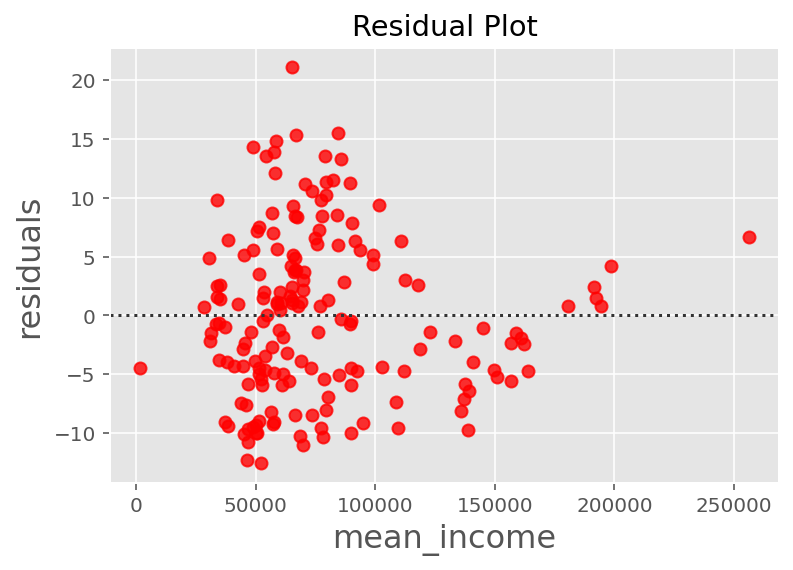

In [28]:
import seaborn as sns
sns.residplot(x, y, color = 'red')
plt.xlabel('mean_income', fontsize = 16)
plt.ylabel('residuals', fontsize = 16)
plt.title('Residual Plot');
plt.show();

The residuals do not show constant variability.<br>
Nearly normal residuals: To check this condition, we can look at a histogram.

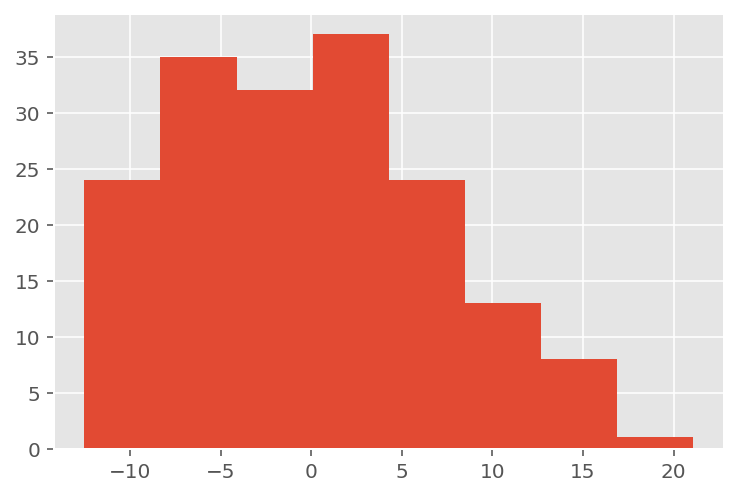

In [29]:
residuals = (y - y_pred)
plt.hist(residuals, bins = 8)
plt.show();

The residuals show some right skewed. 

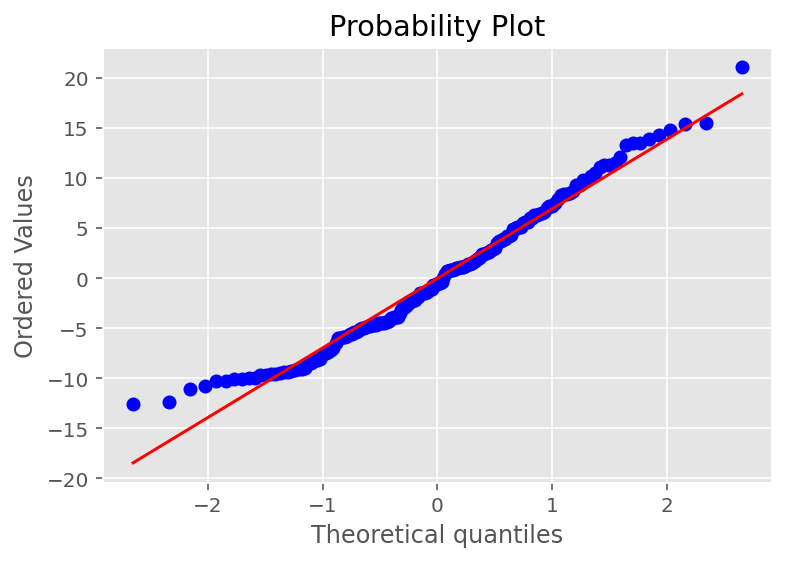

In [30]:
from scipy.stats import probplot
probplot(residuals, plot = plt)
plt.show(); 

Q-Q plot does not follow what would be expected under the normal distribution.

Despite there is a negative association, at least one of the conditions for using linear regression is not met, so I conclude that linear regression is not sufficient to predict <code>positive cases per thousand people</code> from <code>mean_income</code>.

### Multiple Linear Regression

__Sergey Comment__ 3. For the multiple linear regression model you created, there is a clear lurking variable effect, where you are using positive cases per thousand to predict the overall number of positive cases. This is especially clear because that variable has a very large t-value. You should have probably made positive per thousand again the outcome variable here and then regressed that on borough, income variables, and population. This would have given clear evidence of either location or income being predictive of likelihood of a positive case (these in turn are actually proxies of socioeconomic factors).

Adding dummy variables for borough, as it is the only categorical field.

In [31]:
df_with_dummies = pd.get_dummies(covid_data, prefix='borough_', columns=['borough'])

In [32]:
df_with_dummies.head()

,zip_code,covid_positive,covid_tested,ratio,population,density,median_income,mean_income,positive_per_thousand,borough__Bronx,borough__Brooklyn,borough__Manhattan,borough__Queens,borough__Staten
0,10001,341,1552,21.97,22924,13259.3,71245,123113,14.875240,0,0,1,0,0
1,10002,989,3164,31.26,74993,35781.9,30844,46259,13.187898,0,0,1,0,0
2,10003,434,2220,19.55,54682,37524.3,89999,139331,7.936798,0,0,1,0,0
3,10004,30,153,19.61,3028,2214.8,110184,156683,9.907530,0,0,1,0,0
4,10005,59,372,15.86,8831,37900.9,115133,163763,6.681010,0,0,1,0,0


Starting with full model

In [33]:
import statsmodels.api as sm

m_full = sm.formula.ols(formula = 'positive_per_thousand ~ population + density + median_income + mean_income + borough__Bronx + borough__Brooklyn + borough__Manhattan + borough__Queens + borough__Staten', data = df_with_dummies)
multi_reg = m_full.fit()
print(multi_reg.summary())

                              OLS Regression Results                             
Dep. Variable:     positive_per_thousand   R-squared:                       0.564
Model:                               OLS   Adj. R-squared:                  0.543
Method:                    Least Squares   F-statistic:                     26.71
Date:                   Thu, 28 May 2020   Prob (F-statistic):           3.21e-26
Time:                           13:00:14   Log-Likelihood:                -544.94
No. Observations:                    174   AIC:                             1108.
Df Residuals:                        165   BIC:                             1136.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

The full model shows a high adjusted R-squared, explaining 54.3% of the variability found in the number of positive cases per thousand people.
I will use backward elimination, deleting variables with the highest p-value until adjusted R-squared can't be improved.

In [34]:
# excluding borough_manhattan

m_full = sm.formula.ols(formula = 'positive_per_thousand ~ population + density + median_income + mean_income + borough__Bronx + borough__Brooklyn + borough__Queens + borough__Staten', data = df_with_dummies)
multi_reg = m_full.fit()
print(multi_reg.summary())

                              OLS Regression Results                             
Dep. Variable:     positive_per_thousand   R-squared:                       0.564
Model:                               OLS   Adj. R-squared:                  0.543
Method:                    Least Squares   F-statistic:                     26.71
Date:                   Thu, 28 May 2020   Prob (F-statistic):           3.21e-26
Time:                           13:00:14   Log-Likelihood:                -544.94
No. Observations:                    174   AIC:                             1108.
Df Residuals:                        165   BIC:                             1136.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercep

Adjusted R-squared is the same. Delete borough__Brooklyn

In [35]:
# excluding borough__Brooklyn

m_full = sm.formula.ols(formula = 'positive_per_thousand ~ population + density + median_income + mean_income + borough__Bronx + borough__Queens + borough__Staten', data = df_with_dummies)
multi_reg = m_full.fit()
print(multi_reg.summary())

                              OLS Regression Results                             
Dep. Variable:     positive_per_thousand   R-squared:                       0.564
Model:                               OLS   Adj. R-squared:                  0.545
Method:                    Least Squares   F-statistic:                     30.66
Date:                   Thu, 28 May 2020   Prob (F-statistic):           5.96e-27
Time:                           13:00:14   Log-Likelihood:                -545.02
No. Observations:                    174   AIC:                             1106.
Df Residuals:                        166   BIC:                             1131.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept   

Adjusted R-squared is improved a little. Delete median_income

In [36]:
# excluding median_income

m_full = sm.formula.ols(formula = 'positive_per_thousand ~ population + density + mean_income + borough__Bronx + borough__Queens + borough__Staten', data = df_with_dummies)
multi_reg = m_full.fit()
print(multi_reg.summary())

                              OLS Regression Results                             
Dep. Variable:     positive_per_thousand   R-squared:                       0.563
Model:                               OLS   Adj. R-squared:                  0.547
Method:                    Least Squares   F-statistic:                     35.87
Date:                   Thu, 28 May 2020   Prob (F-statistic):           1.10e-27
Time:                           13:00:14   Log-Likelihood:                -545.18
No. Observations:                    174   AIC:                             1104.
Df Residuals:                        167   BIC:                             1126.
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept   

Adjusted R-squared is improved a little. Delete population

In [37]:
# excluding population

m_full = sm.formula.ols(formula = 'positive_per_thousand ~ density + mean_income + borough__Bronx + borough__Queens + borough__Staten', data = df_with_dummies)
multi_reg = m_full.fit()
print(multi_reg.summary())

                              OLS Regression Results                             
Dep. Variable:     positive_per_thousand   R-squared:                       0.558
Model:                               OLS   Adj. R-squared:                  0.545
Method:                    Least Squares   F-statistic:                     42.44
Date:                   Thu, 28 May 2020   Prob (F-statistic):           4.01e-28
Time:                           13:00:14   Log-Likelihood:                -546.15
No. Observations:                    174   AIC:                             1104.
Df Residuals:                        168   BIC:                             1123.
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept   

Adjusted R-squared decreased, so the previous one represents the final model.

In [38]:
# Final model
m_full = sm.formula.ols(formula = 'positive_per_thousand ~ population + density + mean_income + borough__Bronx + borough__Queens + borough__Staten', data = df_with_dummies)
multi_reg = m_full.fit()
print(multi_reg.summary())

                              OLS Regression Results                             
Dep. Variable:     positive_per_thousand   R-squared:                       0.563
Model:                               OLS   Adj. R-squared:                  0.547
Method:                    Least Squares   F-statistic:                     35.87
Date:                   Thu, 28 May 2020   Prob (F-statistic):           1.10e-27
Time:                           13:00:14   Log-Likelihood:                -545.18
No. Observations:                    174   AIC:                             1104.
Df Residuals:                        167   BIC:                             1126.
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept   

__y__ = 23.6291 + 0.00002641 x __population__ -0.00009394 x __density__ -0.0000752 x __mean income__ + 9.5557 x __borough Bronx__ + 6.5033 x __borough Queens__ + 9.6407 x __borough Staten__

### Visualization of Positive cases per thousand of people in zip code

In [39]:
# transforming zip_code from float to int and then to string to match the data type in the geojson file
covid_data["zip_code_str"]=covid_data["zip_code"].astype(int).astype(str) 

The following code uses folium library to plot a choropleth map, using a geojson file that contains the geometry of each zip code using polygon of latitute and longitude coordinates.

In [40]:
import folium
#from folium.plugins import MarkerCluster # for clustering the markers
map = folium.Map(location=[40.693943, -73.985880], default_zoom_start=10)
map.choropleth(geo_data="https://raw.githubusercontent.com/gitjuli/covid-19/master/nyc-zip.code.geojson", # I found this NYC zipcode boundaries by googling 
             data=covid_data, # my dataset
             columns=['zip_code_str', 'positive_per_thousand'], # zip code is here for matching the geojson zipcode, positive_per_thousand is the column that changes the color of zipcode areas
             key_on='feature.properties.postalCode', # this path contains zipcodes in str type, this zipcodes should match with our zip_code_str column
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.3,
             legend_name='Positive Cases Per Thousand People')
map

C:\Users\julir\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


There are some black areas, corresponding to zip codes that did not report cases. In this case I identified them manually, but a function can be created to do that.

In [41]:
missing_zip_codes=['11001','00083','11430','11359','11371','11251','11040','10065','10075','11005']
for i in missing_zip_codes:
    
    #check that the zip code is not in the dataframe
    if (covid_data[covid_data.zip_code == i].count()[0] == 0):
        covid_data = covid_data.append({'zip_code_str': i, 'zip_code': i, 'positive_per_thousand': 0, 'Positive': 0}, ignore_index=True)

In [42]:
map = folium.Map(location=[40.693943, -73.985880], default_zoom_start=9)
map.choropleth(geo_data="https://raw.githubusercontent.com/gitjuli/covid-19/master/nyc-zip.code.geojson", # I found this NYC zipcode boundaries by googling 
             data=covid_data, # my dataset
             columns=['zip_code_str', 'positive_per_thousand'], # zip code is here for matching the geojson zipcode, positive_per_thousand is the column that changes the color of zipcode areas
             key_on='feature.properties.postalCode', # this path contains zipcodes in str type, this zipcodes should match with our zip_code_str column
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.3,
             legend_name='Positive Cases Per Thousand People in Zip Code')
map

In [63]:
import plotly.express as px
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/gitjuli/covid-19/master/nyc-zip.code.geojson') as response:
    geojson = json.load(response)

fig = px.choropleth(covid_data, geojson=geojson, 
                    color="positive_per_thousand",
                    color_continuous_scale="Inferno_r",
                    range_color=(0, 50),
                    locations="zip_code", featureidkey="properties.postalCode",
                    projection="mercator",
                    labels={'positive_per_thousand':'Positive cases per 1000 people', 'zip_code':'zip code'}
                   )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Conclusions

- As of 05/23/2020, when making pairwise comparison between boroughs and positive per thousand people living in them, there is enough statistical evidence to say that the average positive number of cases per thousand people living in Staten Island is greater than the one for people living in Brooklyn and Manhattan but no enough evidence compared to people in Bronx and Queens.

- There is a negative association between mean income and positive cases per thousand people living in each zip code, but mean income ALONE is not enough to use as an indicator to predict positive cases.

- Predicting positive cases per thousand people involves more variables, and based on the multiple linear regression analysis I can see that both borough and zipcode-based income have the highest impact on positive case rate, overall population has a smaller but still significant impact.